<a href="https://colab.research.google.com/github/kzhkAKT/ThermalStatisticalMecanics/blob/draft/TSM01_%E7%86%B1%E7%B5%B1%E8%A8%88%E5%8A%9B%E5%AD%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[教科書](https://www.shokabo.co.jp/mybooks/ISBN978-4-7853-2060-7.htm)

# 熱力学第一法則

## 温度と熱

- [absolute temperature](https://isaacphysics.org/concepts/cp_abs_temperature?stage=all)
- [Mechanical equivalent of heat](https://en.wikipedia.org/wiki/Mechanical_equivalent_of_heat): $W=J\ Q$, [Joule](https://en.wikipedia.org/wiki/Joule) ~ [Calori](https://en.wikipedia.org/wiki/Calori)

### 熱容量と比熱


- [Sensible heat](https://en.wikipedia.org/wiki/Sensible_heat)
- [Latent heat](https://en.wikipedia.org/wiki/Latent_heat)

![https://commons.wikimedia.org/wiki/File:Water_temperature_vs_heat_added.svg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Water_temperature_vs_heat_added.svg/600px-Water_temperature_vs_heat_added.svg.png)

ref: https://commons.wikimedia.org/wiki/File:Water_temperature_vs_heat_added.svg

[Sensible heat](https://en.wikipedia.org/wiki/Sensible_heat)
- $Q = m\ c \ t$, [Specific heat capacity](https://en.wikipedia.org/wiki/Specific_heat_capacity)
  - $C = m c$, [Heat capacity](https://en.wikipedia.org/wiki/Heat_capacity)

- $c_m = M c (= C)$, [Molar heat capacity](https://en.wikipedia.org/wiki/Molar_heat_capacity)


### 融解熱と気化熱

[Latent heat](https://en.wikipedia.org/wiki/Latent_heat), $\quad L=\frac{Q}{m}; Q = m L$
- [Enthalpy of fusion](https://en.wikipedia.org/wiki/Enthalpy_of_fusion)
- [Enthalpy of vaporization](https://en.wikipedia.org/wiki/Enthalpy_of_vaporization)

## 状態量と状態方程式

- [Thermal reservoir](https://en.wikipedia.org/wiki/Thermal_reservoir)
- [State function](https://en.wikipedia.org/wiki/State_function)
  - [Intensive](https://en.wikipedia.org/wiki/Intensive_and_extensive_properties#Intensive_properties) and [extensive properties](https://en.wikipedia.org/wiki/Intensive_and_extensive_properties#Extensive_properties) 

### 状態方程式の例

- $i$:ideal
- $r$:real

1.   $P_i V_i = n R T$
2.   $\left( P_r + a\left( \frac{n}{V}\right)^2 \right) (V_r - n b) = n R T$
  *   $P_i = P_r + a \left( \frac{n}{V}\right) \left( \frac{n}{V}\right)$  : [collision](https://en.wikipedia.org/wiki/Collision)
  *   $V_i + n b  = V_r$: volume change





### 等温線

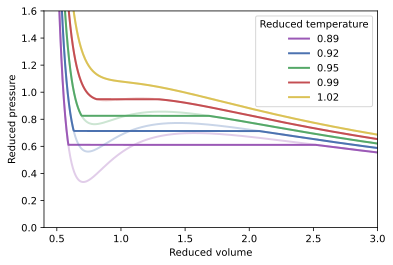

In [ ]:
#@title Van der Waals equation
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# https://scipython.com/blog/the-maxwell-construction/
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import newton
from scipy.signal import argrelextrema

palette = iter(['#9b59b6', '#4c72b0', '#55a868', '#c44e52', '#dbc256'])

# Critical pressure, volume and temperature
# These values are for the van der Waals equation of state for CO2:
# (p - a/V^2)(V-b) = RT. Units: p is in Pa, Vc in m3/mol and T in K.
pc = 7.404e6
Vc = 1.28e-4
Tc = 304

def vdw(Tr, Vr):
    """Van der Waals equation of state.

    Return the reduced pressure from the reduced temperature and volume.

    """

    pr = 8*Tr/(3*Vr-1) - 3/Vr**2
    return pr


def vdw_maxwell(Tr, Vr):
    """Van der Waals equation of state with Maxwell construction.

    Return the reduced pressure from the reduced temperature and volume,
    applying the Maxwell construction correction to the unphysical region
    if necessary.

    """

    pr = vdw(Tr, Vr)
    if Tr >= 1:
        # No unphysical region above the critical temperature.
        return pr

    if min(pr) < 0:
         raise ValueError('Negative pressure results from van der Waals'
                         ' equation of state with Tr = {} K.'.format(Tr))

    # Initial guess for the position of the Maxwell construction line:
    # the volume corresponding to the mean pressure between the minimum and
    # maximum in reduced pressure, pr.
    iprmin = argrelextrema(pr, np.less)
    iprmax = argrelextrema(pr, np.greater)
    Vr0 = np.mean([Vr[iprmin], Vr[iprmax]])

    def get_Vlims(pr0):
        """Solve the inverted van der Waals equation for reduced volume.

        Return the lowest and highest reduced volumes such that the reduced
        pressure is pr0. It only makes sense to call this function for
        T<Tc, ie below the critical temperature where there are three roots.

        """

        eos = np.poly1d( (3*pr0, -(pr0+8*Tr), 9, -3) )
        roots = eos.r
        roots.sort()
        Vrmin, _, Vrmax = roots
        return Vrmin, Vrmax

    def get_area_difference(Vr0):
        """Return the difference in areas of the van der Waals loops.

        Return the difference between the areas of the loops from Vr0 to Vrmax
        and from Vrmin to Vr0 where the reduced pressure from the van der Waals
        equation is the same at Vrmin, Vr0 and Vrmax. This difference is zero
        when the straight line joining Vrmin and Vrmax at pr0 is the Maxwell
        construction.

        """

        pr0 = vdw(Tr, Vr0)
        Vrmin, Vrmax = get_Vlims(pr0)
        return quad(lambda vr: vdw(Tr, vr) - pr0, Vrmin, Vrmax)[0]

    # Root finding by Newton's method determines Vr0 corresponding to
    # equal loop areas for the Maxwell construction.
    Vr0 = newton(get_area_difference, Vr0)
    pr0 = vdw(Tr, Vr0)
    Vrmin, Vrmax = get_Vlims(pr0)

    # Set the pressure in the Maxwell construction region to constant pr0.
    pr[(Vr >= Vrmin) & (Vr <= Vrmax)] = pr0
    return pr

Vr = np.linspace(0.5, 3, 500)

def plot_pV(T):
    Tr = T / Tc
    c = next(palette)
    ax.plot(Vr, vdw(Tr, Vr), lw=2, alpha=0.3, color=c)
    ax.plot(Vr, vdw_maxwell(Tr, Vr), lw=2, color=c, label='{:.2f}'.format(Tr))

fig, ax = plt.subplots()

for T in range(270, 320, 10):
    plot_pV(T)

ax.set_xlim(0.4, 3)
ax.set_xlabel('Reduced volume')
ax.set_ylim(0, 1.6)
ax.set_ylabel('Reduced pressure')
ax.legend(title='Reduced temperature')

plt.show()

In [ ]:
%%svg
https://upload.wikimedia.org/wikipedia/commons/f/f1/MaxwellEqArea.svg

### 偏微分の演算

\begin{align}
f(p,V,T) = 0
\to
\begin{cases}
p =& p(V,T)\\
V =& V(p,T)\\
T =& T(p, V)
\end{cases}
\end{align}

\begin{align}
p(V,T) &\to  p(V+\Delta V, T+\Delta T) \sim p(V+ d V, T+ d T) \\[5mm]
dp &= 
\left(\dfrac{\partial p}{\partial T} \right)_V dT
+
\left(\dfrac{\partial p}{\partial V} \right)_T dV 
\quad
\begin{cases}
\xrightarrow{\Delta V = 0}
 & d p = \left( \dfrac{\partial p}{\partial T}\right)_{V} d T 
 \to 1 = \left( \dfrac{\partial p}{\partial T}\right)_{V} 
 \left( \dfrac{\partial T}{\partial p}\right)_{V} 
 \\
 \xrightarrow{\Delta T = 0}
 & d p = \left( \dfrac{\partial p}{\partial V}\right)_{T} d V
 \to 1 = \left( \dfrac{\partial p}{\partial V}\right)_{T} 
 \left( \dfrac{\partial V}{\partial p}\right)_{T}
\end{cases}
\end{align}


$\require{cancel}$
\begin{align}
\left(\dfrac{\partial p}{\partial T} \right)_V dT
+
\left(\dfrac{\partial p}{\partial V} \right)_T dV 
&= \cancelto{0}{dp}\\
\left(\dfrac{\partial p}{\partial T} \right)_V  
+ \left(\dfrac{\partial p}{\partial V} \right)_T 
\left(\frac{\partial V}{\partial T}\right)_{p}
&= 0\\
\cancelto{1}
{\left(\dfrac{\partial p}{\partial V} \right)_V 
\ \left( \dfrac{\partial T}{\partial p}\right)_{V}}
+ \left(\dfrac{\partial p}{\partial V} \right)_T 
\left(\frac{\partial V}{\partial T}\right)_{p}
\  \left( \dfrac{\partial T}{\partial p}\right)_{V} 
&= 0\\
\left(\dfrac{\partial p}{\partial V} \right)_T 
\left(\frac{\partial V}{\partial T}\right)_{p}
\  \left( \dfrac{\partial T}{\partial p}\right)_{V}  = - 1 
\end{align}

#### [例題4]

\begin{align}
p = \dfrac{RT}{V-b} - \dfrac{a}{V^2}
\begin{cases}
V < b: T<0 (\because p>0)\\
V \geqq b: T>0
\end{cases}
\end{align}

1st
\begin{align}
\dfrac{\partial}{\partial V}_T\left( \left\{ P + a\left( \frac{n}{V}\right)^2 \right\} (V - n b) \right)
&=
\dfrac{\partial}{\partial V}_T \left( n R T\right)\\
%
\left[\left(\frac{\partial p}{\partial V}\right)_{T}
- \frac{2 a}{V^{3}}\right](V-b)+\left(p+\frac{a}{V^{2}}\right)
&=0\\
%
\left[\left(\frac{\partial p}{\partial V}\right)_{T}
- \frac{2 a}{V^{3}}\right](V-b)^2 +
\cancelto{RT}{\left(p+\frac{a}{V^{2}}\right)(V-b)}
&=0\\
%
V^{3}(V-b)^{2}
\cancelto{0}{\left(\frac{\partial p}{\partial V}\right)_{T}}
&=2 a(V-b)^{2}-R T V^{3}\\
%
2 a(V-b)^{2}&=R T V^{3}
\begin{cases}
  y = 2 a(V-b)^{2}\\
  y = R T V^{3}
\end{cases}
\end{align}


2nd
\begin{align}
\dfrac{\partial}{\partial V}_T
\left\{
  \left[\left(\frac{\partial p}{\partial V}\right)_{T}
  - \frac{2 a}{V^{3}}\right](V-b)^2 +{RT}
\right\}
&=0\\
%
\left[\left(\frac{\partial^2 p}{\partial^2 V}\right)_{T}
+3 \frac{2 a}{V^{4}}\right](V-b)^2
+
\left[\left(\frac{\partial p}{\partial V}\right)_{T}
  - \frac{2 a}{V^{3}}\right] 2 (V-b)
- 0
&=0\\
\left[\left(\frac{\partial^2 p}{\partial^2 V}\right)_{T}
+\frac{6 a}{V^{4}}\right](V-b)^3
+
2\cancelto{-RT}{\left[\left(\frac{\partial p}{\partial V}\right)_{T}
  - \frac{2 a}{V^{3}}\right](V-b)^2}
&=0\\
%
\left[\cancelto{0}{\left(\frac{\partial^2 p}{\partial^2 V}\right)_{T}}
+\frac{6 a}{V^{4}}\right](V-b)^3
&=2RT
\end{align}


\begin{cases}
2 a(V-b)^2&=R T V^{3}\\
3 a(V-b)^3&=R T V^4
\end{cases}



\begin{align}
\dfrac{3 a(V_c-b)^3}{2 a(V_c-b)^2} &= \dfrac{R T V_c^4}{R T V_c^{3}}\\
\begin{cases}
V_c &= 3 b\\
T_c &= \dfrac{8a}{27 R b}\\
p_c &= \dfrac{a}{27b^2}
\end{cases}
\end{align}

## 内部エネルギー


- [Avogadro constant](https://en.wikipedia.org/wiki/Avogadro_constant)
  - [物質量の単位「モル」の基礎解説, NIMS](https://unit.aist.go.jp/nmij/public/report/SI_9th/pdf/6_SI_%E3%83%A2%E3%83%AB.pdf)

## 熱力学第一法則


\begin{align}
U_{\rm B} - U_{\rm A} &= W + Q\\
\Delta U_{\rm A} &= \Delta' W + \Delta' Q\\
d U_{\rm A} &= d' W + d' Q\\
\end{align}

--
$d'$ [Inexact differential](https://en.wikipedia.org/wiki/Inexact_differential#Thermodynamics)

### 微小変化の場合

- [Quasistatic process](https://en.wikipedia.org/wiki/Quasistatic_process): $d'W = - p d V$

## 第一法則の応用


\begin{align}
f(p,V,T) =0 \qquad
\begin{cases}
d'W \sim W=W(\bcancel{p},V)\\
d'W \sim Q=Q(\bcancel{*},T)
\end{cases}\\[5mm]
\end{align}

\begin{align}
dU &= d'W + d'Q \\
&= - p dV+ d'Q \\
&\begin{cases}
&U = U(T,V) \\
&dU =
\left(\dfrac{\partial U}{\partial T}\right)_V dT
+
\left(\dfrac{\partial U}{\partial V}\right)_T dV
\end{cases}
\end{align}

\begin{align}
d'Q = \left(\dfrac{\partial U}{\partial T}\right)_V dT
+
\left[ p +\left(\dfrac{\partial U}{\partial V}\right)_T \right] dV
\end{align}
$\frac{d'Q}{dT}$ is related to [sensible heat](https://en.wikipedia.org/wiki/Sensible_heat).

#### 定積(モル)比熱
$dV =0$
\begin{align}
d'Q &= \left(\dfrac{\partial U}{\partial T}\right)_V dT
+
\left[ p +\left(\dfrac{\partial U}{\partial V}\right)_T \right] \cancelto{0}{dV}\\
C_V &= \left(\dfrac{d'Q}{dT}\right)_V = \left(\dfrac{\partial U}{\partial T}\right)_V  \xrightarrow{n = 1} C_{m,V} = \dfrac{d U}{d T}
\end{align}


\begin{align}
C_{m,V} &= \dfrac{d U}{d T}\\
U = \cancelto{0}{U_0} + C_{m,V} T
\end{align}

### 定圧(モル)比熱

$dp=0, n=1$
\begin{align}
d'Q &= \cancelto{\frac{dU}{dT}=C_{m,V}}{\left(\dfrac{\partial U}{\partial T}\right)_V} dT
+
\left[ p +\left(\dfrac{\partial U}{\partial V}\right)_T \right] {dV}\\
C_{m,p} &= \left(\dfrac{d'Q}{dT}\right)_p = C_{m,V} +
\left[ p +\left(\dfrac{\partial U}{\partial V}\right)_T \right]
\left(
  \dfrac{\partial V}{\partial T}
\right)_p
\end{align}

### $U=U'(T,p)$

\begin{align}
&f(p,V,T) =0 \qquad
\begin{cases}
d'W \sim W=W(p,\bcancel{V})\\
d'W \sim Q=Q(\bcancel{*},T)
\end{cases}\\[5mm]
&\begin{cases}
U &= U'(T,p)\\
dU' &= d'W + d'Q = - p dV + d'Q
\end{cases}\\[5mm]
d'Q &= 
\left(\dfrac{\partial U'}{\partial T}\right)_p dT
+
\left(\dfrac{\partial U'}{\partial p}\right)_T \cancelto{0}{dp}
+
p dV\\[7mm]
C_p &= \left(\dfrac{\partial U}{\partial T}\right)_p + p \left(\dfrac{\partial V}{\partial T}\right)_p 
\end{align}

#### [例題2] 
\begin{align}
&\begin{cases}
V=V(T,p)\\
U=U(T,V)
\end{cases} \\
dU &=
\left(\dfrac{\partial U}{\partial T}\right)_V dT
+
\left(\dfrac{\partial U}{\partial V}\right)_T dV\\
&=
\left(\dfrac{\partial U}{\partial T}\right)_V dT
+
\left(\dfrac{\partial U}{\partial V}\right)_T
\left[
\left(\dfrac{\partial V}{\partial T}\right)_p dT
+
\left(\dfrac{\partial V}{\partial p}\right)_T dp
\right]\\
&=
\begin{cases}
\left(\dfrac{\partial U}{\partial T}\right)_V dT
+
\left(\dfrac{\partial U}{\partial V}\right)_T
\left[
\left(\dfrac{\partial V}{\partial T}\right)_p dT
+
\left(\dfrac{\partial V}{\partial p}\right)_T \cancelto{0}{dp}
\right]
%
\xrightarrow{dp = 0} 
\left(\dfrac{\partial U}{\partial T}\right)_p
 =  \left(\dfrac{\partial U}{\partial T}\right)_V
    + \left(\dfrac{\partial U}{\partial V}\right)_T\left(\dfrac{\partial V}{\partial T}\right)_p
\\
%
\left(\dfrac{\partial U}{\partial T}\right)_V \cancelto{0}{dT}
+
\left(\dfrac{\partial U}{\partial V}\right)_T
\left[
\left(\dfrac{\partial V}{\partial T}\right)_p \cancelto{0}{dT}
+
\left(\dfrac{\partial V}{\partial p}\right)_T dp
\right]
\xrightarrow{dT = 0} 
\left(\dfrac{\partial U}{\partial p}\right)_T
= \left(\dfrac{\partial U}{\partial V}\right)_T
\left(\dfrac{\partial V}{\partial p}\right)_T
  %
\end{cases}
\end{align}

#### [例題3]
\begin{align}
&\left(\dfrac{\partial U}{\partial T}\right)_p
 =  \cancelto{C_V}{\left(\dfrac{\partial U}{\partial T}\right)_V}
    + \left(\dfrac{\partial U}{\partial V}\right)_T\left(\dfrac{\partial V}{\partial T}\right)_p\\
%
C_p 
&= \left(\dfrac{\partial U}{\partial T}\right)_p + p \left(\dfrac{\partial V}{\partial T}\right)_p \\[2mm]
&= C_V
 + \left(\dfrac{\partial U}{\partial V}\right)_T\left(\dfrac{\partial V}{\partial T}\right)_p
 + p \left(\dfrac{\partial V}{\partial T}\right)_p \\[2mm]
&= C_V + \left[ \left(\dfrac{\partial U}{\partial V}\right)_T + p\right]
\left(
  \dfrac{\partial V}{\partial T}
\right)_p
\end{align}

## 断熱変化


$d'Q=0$
\begin{align}
\cancelto{0}{d'Q} &= \left(\dfrac{\partial U}{\partial T}\right)_V dT
+
\left[ p +\left(\dfrac{\partial U}{\partial V}\right)_T \right] dV\\[3mm]
Q &= Q(T,V) = const. \to \dfrac{dV}{dT} = f(T,V)
\end{align}

In case of ideal gas $PV=RT$;
$d'Q=0$
\begin{align}
\left(\dfrac{\partial U}{\partial T}\right)_V dT
+
\left[ p +\cancelto{0}{\left(\dfrac{\partial U}{\partial V}\right)_T} \right] dV
 &= 0
\\[2mm]
C_V dT + \cancelto{\frac{RT}{V}}{p} dV &= 0\\[2mm]
C_V \dfrac{dT}{T} + R \dfrac{dV}{V} &= 0\\
\begin{cases}
C_p - C_V = R\\
\gamma = \dfrac{C_p}{C_V} > 1
\end{cases}\\[5mm]
\dfrac{dT}{T} + \left(\gamma -1 \right) \dfrac{dV}{V} &= 0\\[3mm]
\int_{init}^{fin} \dfrac{dT}{T} 
+ \int_{init}^{fin} \left(\gamma -1 \right) \dfrac{dV}{V} 
&= 0\\
\ln T + \left(\gamma -1 \right) \ln V = const.\\[5mm]
T V^{\gamma -1} = const 
\xrightarrow{T = pV/R}
pV^\gamma = const
\end{align}

In [ ]:
#@title ポアッソンの状態方程式を利用した圧縮発火実験
%%html
<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/4qe1Ueifekg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

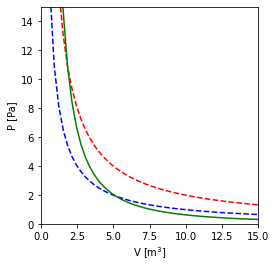

In [ ]:
#@title 断熱変化と等温変化の関係
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0.001, 15, 50)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('P [Pa]')
ax.set_xlabel('V [m$^3$]')

plt.xlim([0,15])
plt.ylim([0,15])

ax.set_aspect('equal', adjustable='box')

plt.plot(x, 10/x, '--', color="b")
plt.plot(x, 2*10/x, '--', color="r")

plt.plot(x, 3*10/x**(1.67), '-', color="g")

## カルノーサイクル

### カルノーサイクルの構成

1. 高温(High)と低温(Low)の等温変化
  - $\color{#FF0000}{T_{\rm H}} > \color{#0000FF}T_{\rm L}$
    - $\color{#FF0000}{\Delta T_{\rm H}}=0$
    - $\color{#0000FF}{\Delta T_{\rm L}}=0$
    
2. それを往復する断熱変化
  - $p_{\rm A}V_{\rm A}^\gamma < \color{green}{p_{\rm C}V_{\rm C}^\gamma}$
    - $p_{\rm D}V_{\rm D}^\gamma = p_{\rm A}V_{\rm A}^\gamma$  
    - $\color{green}{p_{\rm B}V_{\rm B}^\gamma = p_{\rm C}V_{\rm C}^\gamma}$

In [ ]:
#@title カルノーサイクルの動画(その1)
%%html
<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/s3N_QJVucF8" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

#### 4つの過程

ピストンに閉じ込めた気体は $n{\rm \ mol}$ とする. (教科書では$n=1$)


<!--
<img src="https://upload.wikimedia.org/wikipedia/commons/0/0d/Carnot-cycle.jpg" data-canonical-src="https://pt.wikipedia.org/wiki/Ciclo_de_Carnot" width="400" /
![https://ru.wikipedia.org/wiki/%D0%A6%D0%B8%D0%BA%D0%BB_%D0%9A%D0%B0%D1%80%D0%BD%D0%BE](https://upload.wikimedia.org/wikipedia/commons/c/c4/%D0%A6%D0%B8%D0%BA%D0%BB_%D0%9A%D0%B0%D1%80%D0%BD%D0%BE_%D0%BD%D0%B0_%D1%82%D0%B5%D1%80%D0%BC%D0%BE%D0%B4%D0%B8%D0%BD%D0%B0%D0%BC%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9_%D0%BF%D0%BE%D0%B2%D0%B5%D1%80%D1%85%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%B8%D0%B4%D0%B5%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B3%D0%B0%D0%B7%D0%B0.png)-->

- 系は,  **摩擦の影響なく** なめらかに動くピストン
  - 閉じ込められた気体は、(単原子)理想気体
- 正サイクル:: A $\to$ B $\to$ C $\to$ D ($\to$ A)
  - 熱力学第一法則を利用
- 系(ABCDで囲まれた領域)に対して, 
    - 時計回りを 正



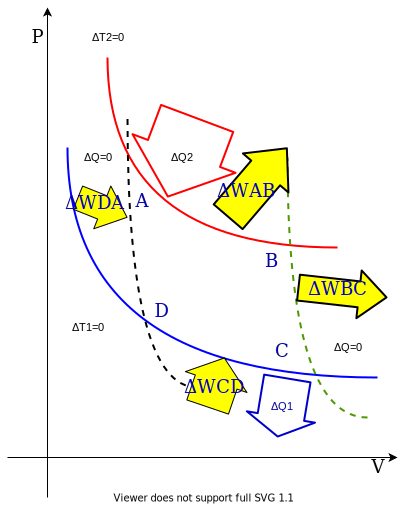

In [ ]:
#@title 簡略化されたカルノーサイクル
%%svg
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.1" width="406px" viewBox="-0.5 -0.5 406 506" content="&lt;mxfile host=&quot;app.diagrams.net&quot; modified=&quot;2020-08-06T07:44:37.423Z&quot; agent=&quot;5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36&quot; etag=&quot;vrub5moJ3pTAYwGPeD6d&quot; version=&quot;13.4.9&quot; type=&quot;google&quot;&gt;&lt;diagram id=&quot;DU0nAm4edodP-iCXRGtb&quot; name=&quot;Page-1&quot;&gt;7Vxbk6I4FP41Vu0+aEECCI9e2u6d2a7t3dmZruq3tESkGo0L2G3Pr9+AAUkIggqoU1pTNXCIh5Dzne9cgt2Bo8Xm3ker+SOxsdcBir3pwHEHAFW1NPpfJPlkEsXUtxLHd20m2wm+uT9xMpBJ166NA25gSIgXuiteOCXLJZ6GnAz5Pvngh82Ix991hRycE3ybIi8vfXbtcL6VaircyR+w68zZnXWTXVigZCx7kGCObPKREcG7Dhz5hITbo8VmhL1o8ZJl2X5vUnA1nZePl2GVL/S/fnkIvgw+/3p/fHh5/MNB5vNjl2l5R96aPS+bbPiZLABe2oNoHenZ1ENB4E47cDgPFx4VqPQwPw+mFNvcyrJZ3WOywKH/SQd87NZTZ4s0zy4lk/nYQ6H7ztsDMbM6qbr0Dk/EpTMByoYHEgOgZiq8hoCs/SlmX8qun6BHU0oUhch3cJhTRA8yT70TxeaRm+rH1/Dj+8t37wkP7p/fXu7DfwjpAl1iK8OjizV06YETHfxIJPQOqTBvUWqYP9Er9VTOkMhznWVkZWpI7FPBO/ZDl3rCgF1YuLYd6Rj6OHB/otdYn0LPV9Ezx6ugDzv6mEpmZBkyX1ZNdj5BC9eLFo8uhu+4KJ1adB+86Ui8md1j50RZmBUDOg81pl3pWQCqnBlBLSDr6pxSFfAKyGwW4FNRIX1e8Os7sM77nQ6OdGBBD2zZfY2cpZ4u2DPjYWxiCcZqdFNQ4qam3ufdVK3HTS1OaeK1zbspPMhNl2SJeQREwEjMQfxwThyyRN7dTjqcrv13bLPhQeiTtzRfAalkRDzix7eDk4lCP1fg/lDj/Rb0j/R/VcgEWo7fMghsg3XkaxwWjP/WJLnQDWJnHdABQFttdhdj90vMuRPC2Sw2bEbE0oDRXSfKxoWU4V95yrCVBevXRAQy4zLimGd2V7aPcr68o36mgnuZqqv0VGAaAqv06yErrc/rVXXYFl9p5+CrDDtFEJ5MpEx28XxlCnWCciRf9Xk9qsh7DfOVDAJN8FVk6tmsdr5Sr4KvvEj9EE3fHJ+sl3biAcyh6mczrYzNdAihwDo1VUiqofGKodkAm0mhfFiXo4Hsy0bBPL0sZSsJo52LwIDY6FCPTbigwGBauwxW3DCpymCqyTPYXmb6W8pMl8U3JzFKsW/tYxQTWILjW/UQilAhdnM6miOUw7ouTRNKLnvSxpaVqe0ul2qgkONoIkNUpRpgCVTTcnGXb+4IVCNNfTQ7tlOeYJJ0ZoWWddFUlAbF6vhbuMfrl/NdPVPnWVM28V+STMvaYoomkl6yD3WiIwqlJmgtNesf5Tj5Hsfh1UjWSVIoV2h4VMRfMEer6HDm4Q0LBMOyTnye5+k3klOobs+T5q3WM/pUkhB135BFgrTLV6XQuNw4IaakuUyyckoqBBwgbiY0HCdUWSlyWlVdhuOiQrhBHO8HWx7l0QSE5s9oVNQWiq8ksNMMzin0ngWvAc5WTS0iIPaajJbhXCERPieAZq7ncWwY8WEGPkDn4GP2dP0K4AMFNoTHFuhQwCFsmQ2BDD4l+SPLByIm9J3X3+iE6T96eyVz9Ht0GGcFYra5hzuPSpQbmM1zaYPz+HkUFRqV+yFANuPhqDCYyCNP+6n6AbveMh5psE27h1f37jqpQiVwYpe2hSZshT2lS44VsM/n39QG5hUECyA0YUFtLZaW96NAaepcuL10aKlYJUy41fl6KxoU0uHFNDSujSVLd7P4rawTWyUtUKRsx6JlilRPoEhNE9JpVbsGhhTfEBbfDKzMkIDvosG23xAufsXogHSaZY0sZSzMW2PiajKRPmEe+ym5naXIB4DRuDQA8Ot1CwBlAUAvDQAqPDExTnvvQLGyH8XkfL0LepahZD6t7UWqsr2nKwoa19mDERpvuT7yse9I5NLzpmNG8Wtet5hx/pgxHtxiRs0xwyiNGcIvhE786UELEeC4TdR8ZcwK1aoVKbVJyONKRAtahyRg2DgIdhKYZcIIF4MEYYyi+NWY8m3Pfb99ERAtg24hOCtEqSL6T2qRTBSDkigmlihZ/HHwOhhLZq1YqtzduGHpZCwBQ8BS/9xYsmrFUvEuww1LtWNJeE8CGmfGUhLfa8LS+Ial9mKc+MNb0BiW6OnuDyps06vdn6WAd/8D&lt;/diagram&gt;&lt;/mxfile&gt;" onclick="(function(svg){var src=window.event.target||window.event.srcElement;while (src!=null&amp;&amp;src.nodeName.toLowerCase()!='a'){src=src.parentNode;}if(src==null){if(svg.wnd!=null&amp;&amp;!svg.wnd.closed){svg.wnd.focus();}else{var r=function(evt){if(evt.data=='ready'&amp;&amp;evt.source==svg.wnd){svg.wnd.postMessage(decodeURIComponent(svg.getAttribute('content')),'*');window.removeEventListener('message',r);}};window.addEventListener('message',r);svg.wnd=window.open('https://viewer.diagrams.net/?client=1&amp;edit=_blank');}}})(this);" style="cursor:pointer;max-width:100%;max-height:506px;"><defs/><g><path d="M 7 457 L 390.63 457" fill="none" stroke="#000000" stroke-miterlimit="10" pointer-events="stroke"/><path d="M 395.88 457 L 388.88 460.5 L 390.63 457 L 388.88 453.5 Z" fill="#000000" stroke="#000000" stroke-miterlimit="10" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 468px; margin-left: 378px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 18px; font-family: Georgia; color: #000000; line-height: 1.2; pointer-events: all; background-color: #ffffff; white-space: nowrap; "><i>V</i></div></div></div></foreignObject><text x="378" y="473" fill="#000000" font-family="Georgia" font-size="18px" text-anchor="middle">V</text></switch></g><path d="M 47 497 L 47 13.37" fill="none" stroke="#000000" stroke-miterlimit="10" pointer-events="stroke"/><path d="M 47 8.12 L 50.5 15.12 L 47 13.37 L 43.5 15.12 Z" fill="#000000" stroke="#000000" stroke-miterlimit="10" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 38px; margin-left: 38px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 18px; font-family: Georgia; color: #000000; line-height: 1.2; pointer-events: all; font-style: italic; background-color: #ffffff; white-space: nowrap; ">P</div></div></div></foreignObject><text x="38" y="43" fill="#000000" font-family="Georgia" font-size="18px" text-anchor="middle" font-style="italic">P</text></switch></g><path d="M 337 247 Q 107 247 107 57" fill="none" stroke="#ff0000" stroke-width="2" stroke-miterlimit="10" pointer-events="stroke"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 38px; margin-left: 108px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 11px; font-family: Helvetica; color: #000000; line-height: 1.2; pointer-events: all; background-color: #ffffff; white-space: nowrap; "><font style="font-size: 24px" color="#ff0000">Δ<i>T</i><sub>2</sub>=0</font></div></div></div></foreignObject><text x="108" y="41" fill="#000000" font-family="Helvetica" font-size="11px" text-anchor="middle">ΔT2=0</text></switch></g><path d="M 377 377 Q 67 377 67 147" fill="none" stroke="#0000ff" stroke-width="2" stroke-miterlimit="10" pointer-events="stroke"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 328px; margin-left: 88px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 11px; font-family: Helvetica; color: #000000; line-height: 1.2; pointer-events: all; white-space: nowrap; "><font style="font-size: 24px" color="#0000ff">Δ<i>T</i><sub>1</sub>=0</font></div></div></div></foreignObject><text x="88" y="331" fill="#000000" font-family="Helvetica" font-size="11px" text-anchor="middle">ΔT1=0</text></switch></g><path d="M 197 387 Q 127 387 127 117" fill="none" stroke="#000000" stroke-width="2" stroke-miterlimit="10" stroke-dasharray="6 6" pointer-events="stroke"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 158px; margin-left: 98px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 11px; font-family: Helvetica; color: #000000; line-height: 1.2; pointer-events: all; background-color: #ffffff; white-space: nowrap; "><font style="font-size: 18px">Δ<i>Q</i>=0</font></div></div></div></foreignObject><text x="98" y="161" fill="#000000" font-family="Helvetica" font-size="11px" text-anchor="middle">ΔQ=0</text></switch></g><path d="M 367 417 Q 287 417 287 157" fill="none" stroke="#4d9900" stroke-width="2" stroke-miterlimit="10" stroke-dasharray="6 6" pointer-events="stroke"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 348px; margin-left: 348px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 11px; font-family: Helvetica; color: #000000; line-height: 1.2; pointer-events: all; background-color: #ffffff; white-space: nowrap; "><font color="#4d9900"><span style="font-size: 18px">Δ</span><i style="font-size: 18px">Q</i><span style="font-size: 18px">=0</span></font></div></div></div></foreignObject><text x="348" y="351" fill="#000000" font-family="Helvetica" font-size="11px" text-anchor="middle">ΔQ=0</text></switch></g><path d="M 160.6 104.42 L 232.7 131.45 L 219.55 166.5 L 235 172.29 L 167.35 196.06 L 132.01 133.67 L 147.46 139.46 Z" fill="none" stroke="#ff0000" stroke-width="2" stroke-linejoin="round" stroke-miterlimit="10" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 157px; margin-left: 182px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 11px; font-family: Helvetica; color: #000000; line-height: 1.2; pointer-events: all; white-space: nowrap; "><font color="#ff0000" style="font-size: 24px">ΔQ<sub>2</sub></font></div></div></div></foreignObject><text x="182" y="161" fill="#000000" font-family="Helvetica" font-size="11px" text-anchor="middle">ΔQ2</text></switch></g><path d="M 263.66 374.12 L 310.02 381.85 L 303.6 420.36 L 314.45 422.16 L 277.16 436.01 L 246.39 410.82 L 257.24 412.63 Z" fill="none" stroke="#0000cc" stroke-width="2" stroke-linejoin="round" stroke-miterlimit="10" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 407px; margin-left: 282px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 11px; font-family: Helvetica; color: #0000CC; line-height: 1.2; pointer-events: all; white-space: nowrap; "><font style="font-size: 24px">ΔQ<sub>1</sub></font></div></div></div></foreignObject><text x="282" y="410" fill="#0000CC" font-family="Helvetica" font-size="11px" text-anchor="middle">ΔQ1</text></switch></g><path d="M 296.56 300.03 L 299.43 274.19 L 359.96 280.92 L 361.18 269.98 L 386.01 296.89 L 355.87 317.69 L 357.09 306.76 Z" fill="#ffff00" stroke="#000000" stroke-width="2" stroke-linejoin="round" stroke-miterlimit="10" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 290px; margin-left: 337px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 18px; font-family: Georgia; color: #0000CC; line-height: 1.2; pointer-events: all; white-space: nowrap; "><span style="color: rgb(0 , 0 , 0) ; font-size: 14px">Δ</span><i style="color: rgb(0 , 0 , 0) ; font-size: 14px">W</i><sub style="color: rgb(0 , 0 , 0)"><font style="font-size: 12px">BC</font></sub></div></div></div></foreignObject><text x="337" y="295" fill="#0000CC" font-family="Georgia" font-size="18px" text-anchor="middle">ΔWBC</text></switch></g><path d="M 242.08 228.61 L 213.22 203.88 L 250.75 160.1 L 242.39 152.94 L 286.35 147.76 L 287.95 191.99 L 279.6 184.83 Z" fill="#ffff00" stroke="#000000" stroke-width="2" stroke-linejoin="round" stroke-miterlimit="10" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 191px; margin-left: 246px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 18px; font-family: Georgia; color: #0000CC; line-height: 1.2; pointer-events: all; white-space: nowrap; "><font color="#000000" style="font-size: 14px">Δ<i>W</i><sub>AB</sub></font></div></div></div></foreignObject><text x="246" y="197" fill="#0000CC" font-family="Georgia" font-size="18px" text-anchor="middle">ΔWAB</text></switch></g><path d="M 227.99 413.61 L 186.33 399.44 L 194.83 374.46 L 184.89 371.08 L 223.84 357.47 L 246.43 392 L 236.49 388.62 Z" fill="#ffff00" stroke="#000000" stroke-linejoin="round" stroke-miterlimit="10" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 387px; margin-left: 214px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 18px; font-family: Georgia; color: #0000CC; line-height: 1.2; pointer-events: all; white-space: nowrap; "><span style="color: rgb(0 , 0 , 0) ; font-size: 14px">Δ</span><i style="color: rgb(0 , 0 , 0) ; font-size: 14px">W</i><span style="color: rgb(0 , 0 , 0) ; font-size: 14px"><sub>CD</sub></span></div></div></div></foreignObject><text x="214" y="393" fill="#0000CC" font-family="Georgia" font-size="18px" text-anchor="middle">ΔWCD</text></switch></g><path d="M 72.82 208.79 L 82.11 185.58 L 106.43 195.31 L 110.33 185.56 L 126.54 216.81 L 93.25 228.27 L 97.15 218.52 Z" fill="#ffff00" stroke="#000000" stroke-linejoin="round" stroke-miterlimit="10" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 203px; margin-left: 95px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 18px; font-family: Georgia; color: #0000CC; line-height: 1.2; pointer-events: all; white-space: nowrap; "><span style="color: rgb(0 , 0 , 0) ; font-size: 14px">Δ</span><i style="color: rgb(0 , 0 , 0) ; font-size: 14px">W</i><span style="color: rgb(0 , 0 , 0) ; font-size: 14px"><sub>DA</sub></span></div></div></div></foreignObject><text x="95" y="209" fill="#0000CC" font-family="Georgia" font-size="18px" text-anchor="middle">ΔWDA</text></switch></g><rect x="127" y="187" width="30" height="30" fill="none" stroke="none" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 202px; margin-left: 142px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 18px; font-family: Georgia; color: #0000CC; line-height: 1.2; pointer-events: all; white-space: nowrap; "><font color="#000000">A</font></div></div></div></foreignObject><text x="142" y="207" fill="#0000CC" font-family="Georgia" font-size="18px" text-anchor="middle">A</text></switch></g><rect x="257" y="247" width="30" height="30" fill="none" stroke="none" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 262px; margin-left: 272px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 18px; font-family: Georgia; color: #0000CC; line-height: 1.2; pointer-events: all; white-space: nowrap; "><font color="#000000">B</font></div></div></div></foreignObject><text x="272" y="267" fill="#0000CC" font-family="Georgia" font-size="18px" text-anchor="middle">B</text></switch></g><rect x="267" y="337" width="30" height="30" fill="none" stroke="none" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 352px; margin-left: 282px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 18px; font-family: Georgia; color: #0000CC; line-height: 1.2; pointer-events: all; white-space: nowrap; "><font color="#000000">C</font></div></div></div></foreignObject><text x="282" y="357" fill="#0000CC" font-family="Georgia" font-size="18px" text-anchor="middle">C</text></switch></g><rect x="147" y="297" width="30" height="30" fill="none" stroke="none" pointer-events="all"/><g transform="translate(-0.5 -0.5)"><switch><foreignObject style="overflow: visible; text-align: left;" pointer-events="none" width="100%" height="100%" requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"><div xmlns="http://www.w3.org/1999/xhtml" style="display: flex; align-items: unsafe center; justify-content: unsafe center; width: 1px; height: 1px; padding-top: 312px; margin-left: 162px;"><div style="box-sizing: border-box; font-size: 0; text-align: center; "><div style="display: inline-block; font-size: 18px; font-family: Georgia; color: #0000CC; line-height: 1.2; pointer-events: all; white-space: nowrap; "><font color="#000000">D</font></div></div></div></foreignObject><text x="162" y="317" fill="#0000CC" font-family="Georgia" font-size="18px" text-anchor="middle">D</text></switch></g></g><switch><g requiredFeatures="http://www.w3.org/TR/SVG11/feature#Extensibility"/><a transform="translate(0,-5)" xlink:href="https://desk.draw.io/support/solutions/articles/16000042487" target="_blank"><text text-anchor="middle" font-size="10px" x="50%" y="100%">Viewer does not support full SVG 1.1</text></a></switch></svg>

$\require{cancel}$
##### (過程1) A $\to$ B: 等温膨張

$\Delta T_2 =0 $ で熱力学第一法則をこの過程: A$\to$B 適用すると
\begin{align*}
\Delta U_{\rm AB} &= n \left( \dfrac{3}{2} R \cancelto{0}{\Delta T_2}\right) = 0 = \Delta Q _{\rm AB}　 + \left( - \Delta W_{\rm AB} \right)&\\
\Delta U_{\rm AB} & = 0 = \Delta Q _{2}-\Delta W_{\rm AB}&
\end{align*}

\begin{align}
\Delta W_{\rm AB} &= \Delta Q _{2}
= \int_{\rm A}^{\rm B} P {\rm d}V = \int_{\rm A}^{\rm B} \dfrac{nRT_{\rm 2}}{V} {\rm d}V \\[2mm]
Q_{\rm H} &=  W_1 = \cancelto{1}{n} \cdot R T_{\rm H} \ln \dfrac{V_2}{V_1}
\end{align}

##### (過程2) B $\to$ C: 断熱膨張

$\Delta Q_{\rm BC} =0 $ で熱力学第一法則をこの過程: B$\to$C 適用すると
\begin{align*}
\Delta U_{\rm BC} &= \cancelto{0}{\Delta Q_{\rm BC}} -  \Delta W_{\rm BC}&\\[2mm]
\Delta U_{\rm BC} &= - \Delta W_{\rm BC}&
\end{align*}

\begin{align*}
\Delta W_{\rm BC} &= - \Delta U_{\rm BC}= - \left(U_{\rm C} - U_{\rm B}\right)&\\[2mm]
W_2 &=  U(T_{H}) - U(T_{L})
\end{align*}

##### (過程3) C $\to$ D: 等温圧縮

$\Delta T_1 =0 $ で熱力学第一法則をこの過程: C$\to$D 適用すると
\begin{align*}
\Delta U_{\rm CD} &= n \left( \dfrac{3}{2} R \cancelto{0}{\Delta T_1}\right) = 0 = \left( -\Delta Q_{\rm CD} \right)+ \Delta W_{\rm CD}&\\
\Delta U_{\rm CD} & = 0 = -\Delta Q _{\rm 1} + \Delta W_{\rm CD}&
\end{align*}


\begin{align*}
\Delta Q _{\rm 1} &= \Delta W_{\rm CD}= {n} \cdot R T_{\rm L} \ln \dfrac{V_D}{V_C} < 0\\
- Q_{\rm L} &= W_3 = \cancelto{1}{n} \cdot R T_{\rm L} \ln \dfrac{V_4}{V_3} 
\end{align*}

##### (過程4) D $\to$ A: 断熱圧縮

$\Delta Q_{\rm DA} =0 $ で熱力学第一法則をこの過程: D$\to$A 適用すると
\begin{align*}
\Delta U_{\rm DA} &= \cancelto{0}{\Delta Q_{\rm DA}} +  \Delta W_{\rm DA}&\\
\Delta U_{\rm DA} &= \Delta W_{\rm DA}&
\end{align*}

\begin{align*}
\Delta W_{\rm DA} &= - \Delta U_{\rm DA}= - \left(U_{\rm A} - U_{\rm D}\right)&\\[2mm]
W_2 &=  U(T_{L}) - U(T_{H})
\end{align*}

###### 断熱変化で成り立つ関係

\begin{align}
&\begin{cases}
T_{H}V_{2}^{\gamma-1} &= T_{L}V_{3}^{\gamma-1} \quad : \text{at B and C}\\[2mm]
T_{H}V_{1}^{\gamma-1} &= T_{L}V_{4}^{\gamma-1} \quad : \text{at D and A}
\end{cases}
\end{align}
上段の式と下段の式を辺々の商を取ると
\begin{align}
\dfrac{V_{2}^{\gamma-1}}{V_{1}^{\gamma-1}}
&=\dfrac{V_{3}^{\gamma-1}}{V_{4}^{\gamma-1}}\\[2mm]
{}^{\gamma-1}\sqrt{\left(\dfrac{V_{2}}{V_{1}}\right)^{\gamma-1}}
&=
{}^{\gamma-1}\sqrt{
\left(\dfrac{V_{3}}{V_{4}}\right)^{\gamma-1}}\\[2mm]
\dfrac{V_{2}}{V_{1}}
&=\dfrac{V_{3}}{V_{4}}
\end{align}


#### 1サイクルで行う仕事 $W$

\begin{align*}
&\begin{cases}
W_1&= Q_{\rm H}=R T_{\rm H} \ln \dfrac{V_2}{V_1}\\
W_2&= U(T_{H}) - U(T_{L})\\
W_3&= -Q_{\rm L}= RT_{\rm L} \ln \dfrac{V_4}{V_3} = - RT_{\rm L} \ln \dfrac{V_2}{V_1}  \\
W_4&= U(T_{L}) - U(T_{H})
\end{cases}\\
W 
&= \sum_{1}^{4} W_i = W_1 + W_3 = Q_{\rm H} + (- Q_{\rm L})\\
&= R\left( T_{\rm H}  - T_{\rm L} \right) \ln \dfrac{V_2}{V_1}
\end{align*}

> カルノー機関が1サイクルで行う仕事は図の内部の面積に等しい

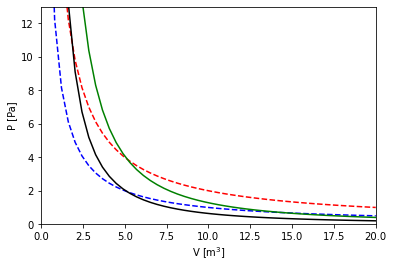

In [ ]:
#@title カルノーサイクルの描画
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0.001, 20, 50)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('P [Pa]')
ax.set_xlabel('V [m$^3$]')

plt.xlim([0,20])
plt.ylim([0,13])

#ax.set_aspect('equal', adjustable='box')

plt.plot(x, 10/x, '--', color="b")
plt.plot(x, 2*10/x, '--', color="r")

plt.plot(x, 3*10/x**(1.67), '-', color="k")
plt.plot(x, 2*3*10/x**(1.67), '-', color="g")

$\require{cancel}$
##### カルノー機関の熱効率 $\eta$

\begin{align*}
\eta &= \dfrac{Q_{\rm H} -Q_{\rm L}}{Q_{\rm H}} 
= \dfrac{\cancel{R}\left( T_{\rm H}  - T_{\rm L} \right) \bcancel{\ln \dfrac{V_2}{V_1}}}
{\cancel{R} T_{\rm H} \bcancel{\ln \dfrac{V_2}{V_1}}}
= \dfrac{T_{\rm H} -T_{\rm L}}{T_{\rm H}} &\\[1mm]
%
&=1 - \dfrac{Q_{\rm L}}{Q_{\rm H}} 
=1 - \dfrac{T_{\rm L}}{T_{\rm H}} \\[3mm]
\dfrac{Q_{\rm L}}{Q_{\rm H}} 
&=
\dfrac{T_{\rm L}}{T_{\rm H}} 
\end{align*}


#### クラウジウスの式

絶対温度($T_1>T_2>0$)を考慮し、サイクルを行う機関が受け取る熱と仕事を正として熱効率を立て直すと

\begin{align*}
\eta &= \dfrac{-W}{Q_1} = 
\dfrac{Q_1 + Q_2}{Q_2} 
= \dfrac{T_{\rm H} -T_{\rm L}}{T_{\rm H}} &\\[1mm]
\dfrac{Q_{\rm 2}}{Q_{\rm 1}} 
&=
- \dfrac{T_2}{T_1} \\[3mm]
\dfrac{Q_1}{T_1} + \dfrac{Q_2}{T_2} &= 0
\end{align*}